In [1]:
# global settings

N_CPU = 12 # number of CPUs for parallel operations

## Data Sets

QSPRPred package defines the `QSPRDataset` class, which is used to manage data and supply it to the models of interest. We will use example data sets that can be loaded via the `datasets.py` module defined in the current folder. Data sets can be created in a variety of ways so we encourage the reader to examine the documented examples in `datasets.py`.

## Building Models - Regression

### Preparing the Data

We will start with a regression example, which uses  the `Parkinsons` data set:

In [2]:
from datasets import Parkinsons

dataset = Parkinsons()

Number of samples per target:
GABAAalpha    6280
NMDA          4073
P41594        2730
Q13255         975
Q14643          12
Name: accession, dtype: int64


We will built a regression model for the GABA(A) receptor subunit alpha (GABAAalpha).
Therefore, we initialize our QSPRdataset as regression for "GABAAalpha".
After this we need to do some processing of the data.
We need to calculate compound features, split our dataset into a train and test set.

In [3]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import randomsplit
from qsprpred.models.tasks import ModelTasks

# create folder to save models and data
os.makedirs('qspr/models', exist_ok=True)

# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(descsets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = randomsplit(0.2)


# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculator=feature_calculator,
    feature_standardizers=[Scaler()]
)
dataset.save()

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Parallel apply in progress for tutorial_data.:   0%|          | 0/2 [00:00<?, ?it/s]

Missing values filled with 0


Number of samples train set: 1845
Number of samples test set: 205


### Training the Model

After preparing our dataset, we will train a QSPR regression model.
In this tutorial we will train a XGBoost model as it generally performs well, but there are other model types
available. Most machine learning models have tunable hyperparameters (for example depth & learning rate), as some hyperparameter combinations will lead to better performance on a task we perform hyperparameter optimization (in which different combinations are tested and evaluated on a subset of the training data). After finding good hyperparameters a model will be trained on the training data & evaluated on the test data. In addition to this the final model will be trained on all data

In [4]:
from qsprpred.models.models import QSPRsklearn
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
model = QSPRsklearn(base_dir = '.', data=dataset, alg = PLSRegression(), alg_name='PLS')

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
# the best hyperparameter combination will be saved in PLS_REG_GABAAalpha_params.json
search_space_bs = {"n_components": ["int", 1, 20], "scale": ["categorical", [True, False]]}
model.bayesOptimization(search_space_bs=search_space_bs, n_trials=5, n_jobs=4)

#Then we will evaluate the performance of the best model using the independent test set
_ = model.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
# model is saved under qsprmodels/PLS_REG_GABAAalpha.pkg
model.fit()


At the moment n_jobs>1 not available for bayesoptimization. n_jobs set to 1
[I 2023-02-09 13:34:53,156] A new study created in memory with name: no-name-5b7a4cb6-39be-4156-a84c-12ed23cbb786


Bayesian optimization can take a while for some hyperparameter combinations
{'n_components': 5, 'scale': False}


[I 2023-02-09 13:34:54,312] Trial 0 finished with value: 0.652834455870487 and parameters: {'n_components': 5, 'scale': False}. Best is trial 0 with value: 0.652834455870487.


{'n_components': 19, 'scale': False}


[I 2023-02-09 13:34:57,400] Trial 1 finished with value: 0.47509471961060934 and parameters: {'n_components': 19, 'scale': False}. Best is trial 0 with value: 0.652834455870487.


{'n_components': 8, 'scale': True}


[I 2023-02-09 13:34:59,066] Trial 2 finished with value: 0.6242497957924594 and parameters: {'n_components': 8, 'scale': True}. Best is trial 0 with value: 0.652834455870487.


{'n_components': 10, 'scale': False}


[I 2023-02-09 13:35:00,970] Trial 3 finished with value: 0.5923307535120675 and parameters: {'n_components': 10, 'scale': False}. Best is trial 0 with value: 0.652834455870487.


{'n_components': 2, 'scale': True}


[I 2023-02-09 13:35:01,854] Trial 4 finished with value: 0.5947303951539111 and parameters: {'n_components': 2, 'scale': True}. Best is trial 0 with value: 0.652834455870487.


## Evaluating the results

Plotting the results of our model on the test set we can see that it is performing well.

PLS Cross Validation: (R^2=0.65, RMSE=0.81)
PLS Independent Test: (R^2=0.63, RMSE=0.79)


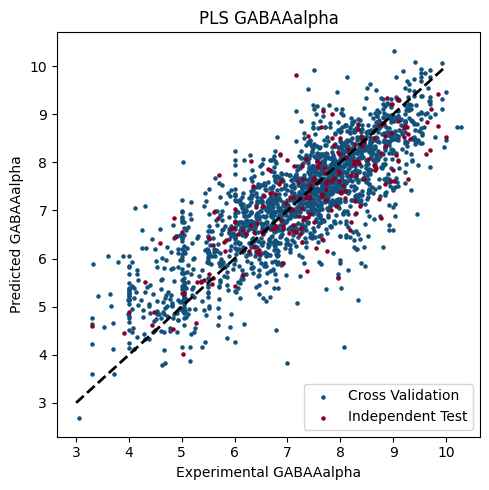

In [5]:
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd

def QSPR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    my_cmap = ["#12517B", "#88002A"]

    plt.figure(figsize=(5, 5))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation', 'Independent Test']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=5, label=legend, color=my_cmap[j])
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                print('%s %s: (R^2=%.2f, RMSE=%.2f)' % (model, legend,coef,rmse))

            plt.title('%s %s' % (model,target))
            plt.xlabel(f"Experimental {target}")
            plt.ylabel(f"Predicted {target}")
            plt.plot([3, 10], [3, 10], lw=2, linestyle='--', color='black')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

# create folder for figures
if not os.path.isdir('figures'):
    os.mkdir('figures')

QSPR_REG_scatterplot(f"qspr/models",
                     ["GABAAalpha"], 
                     ["PLS"],
                      out="figures/GABAAalpha_scatterplot.png")

## Building Models - Classification

### Preparing the Data

We will repeat the same steps as with the regression model, but this time with classification data loaded from `datasets.py`:

In [8]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import FingerprintSet, rdkit_descs
from qsprpred.data.utils.datasplitters import scaffoldsplit
from qsprpred.data.utils.featurefilters import lowVarianceFilter, highCorrelationFilter
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.models.tasks import ModelTasks
from qsprpred.data.utils.scaffolds import Murcko
from datasets import A2AR

# create folder to save models and data
os.makedirs('qspr/data', exist_ok=True)
os.makedirs('qspr/models', exist_ok=True)

# intialize the dataset
dataset = A2AR()

# split on scaffolds
split = scaffoldsplit(dataset=dataset, scaffold=Murcko(), test_fraction=0.2)

# Remove features that have a low variance (<0.05) in the trainingset
lv = lowVarianceFilter(0.05)

# Remove features that have a high correlation (>0.9) in the trainingset
hc = highCorrelationFilter(0.8)

dataset.prepareDataset(
    split=split,
    feature_calculator=feature_calculator,
    feature_filters=[lv, hc]
)

# save the data set if you do not want to recalculate descriptors
# dataset.save()

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")

You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches to this command.
Number of files to be downloaded: 3
Total size: 106MB


Reading data from data...
Read all data.
Initialized filters.


0it [00:00, ?it/s]

Number of compounds:4296
Wrote data to file 'data/A2A_LIGANDS.tsv'.
Number of samples loaded: 4296


Parallel apply in progress for A2A_LIGANDS.:   0%|          | 0/4 [00:00<?, ?it/s]

Missing values filled with 0


Parallel apply in progress for A2A_LIGANDS.:   0%|          | 0/4 [00:00<?, ?it/s]

Number of samples train set: 3429
Number of samples test set: 867, 20.181564245810055%


In [9]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

params = {
    'n_estimators' : [50, 200],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    "n_jobs": [1]
}


fitted_models = []
for model in [ExtraTreesClassifier, RandomForestClassifier]:
    model = QSPRsklearn(
        base_dir='.',
        data=dataset, 
        alg = model(), 
        alg_name=model.__name__
    )

    model.gridSearch(search_space_gs=params, n_jobs=N_CPU)
    model.evaluate()
    model.fit()
    
    fitted_models.append(model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


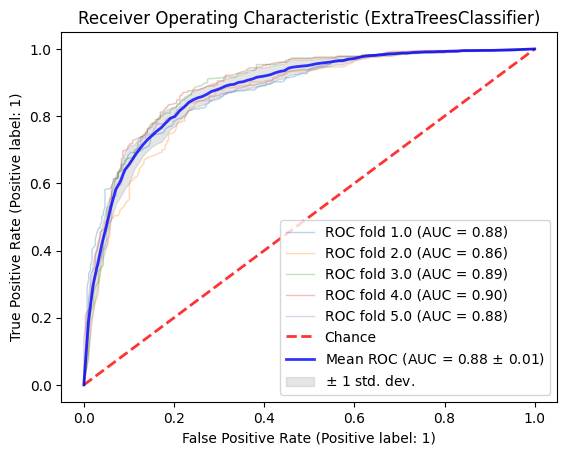

<Figure size 640x480 with 0 Axes>

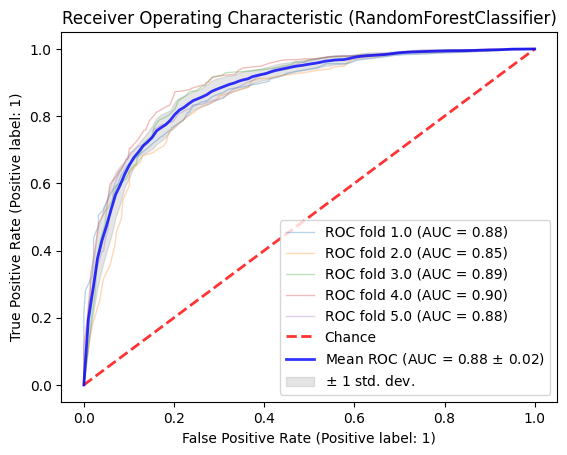

[<AxesSubplot: title={'center': 'Receiver Operating Characteristic (ExtraTreesClassifier)'}, xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>,
 <AxesSubplot: title={'center': 'Receiver Operating Characteristic (RandomForestClassifier)'}, xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>]

<Figure size 640x480 with 0 Axes>

In [10]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot(fitted_models)
plot.make('cv', save = True, show=True)

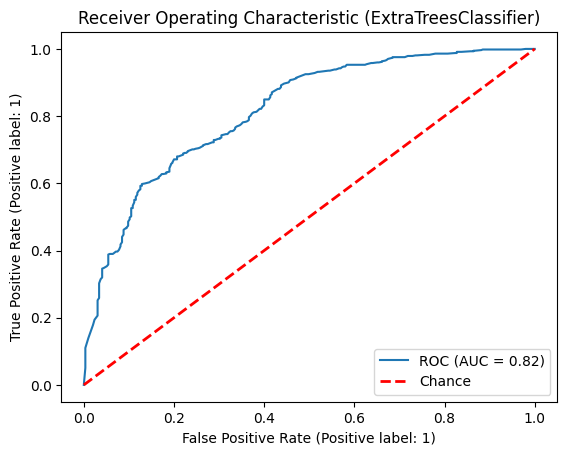

<Figure size 640x480 with 0 Axes>

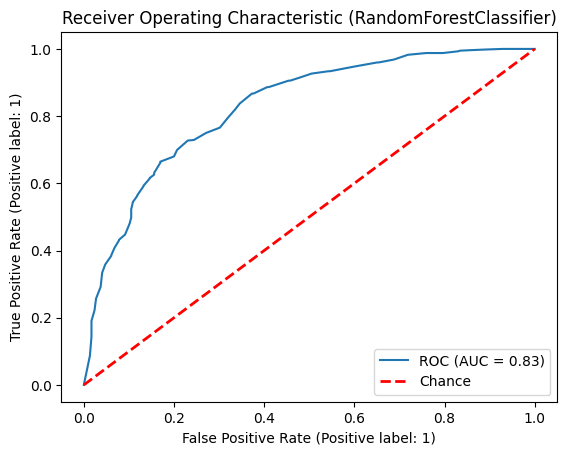

[<AxesSubplot: title={'center': 'Receiver Operating Characteristic (ExtraTreesClassifier)'}, xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>,
 <AxesSubplot: title={'center': 'Receiver Operating Characteristic (RandomForestClassifier)'}, xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>]

<Figure size 640x480 with 0 Axes>

In [11]:
plot.make('ind', save = True, show=True)

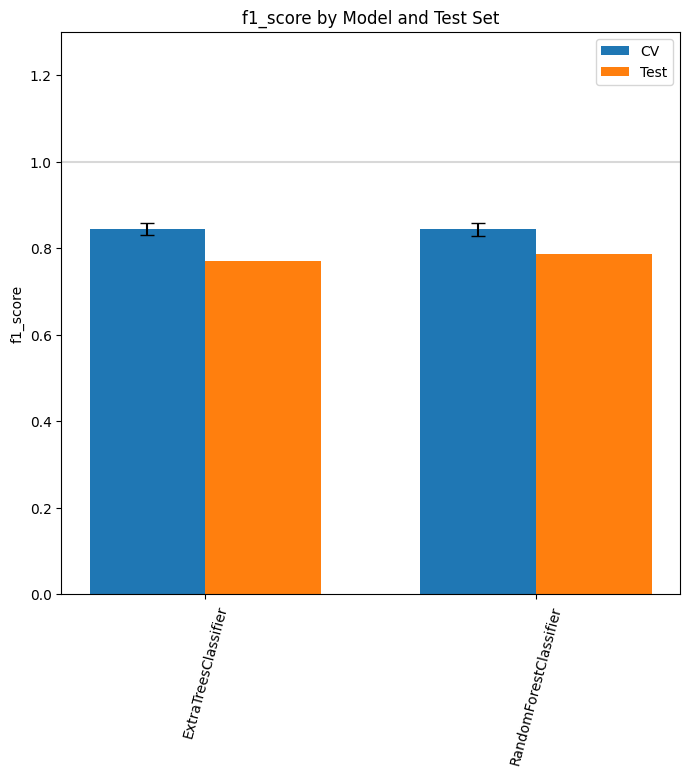

<Figure size 640x480 with 0 Axes>

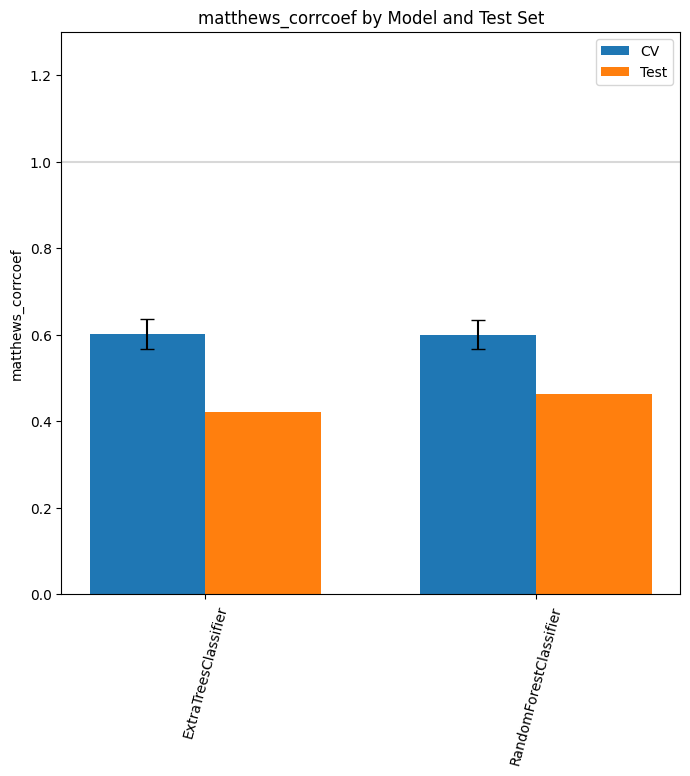

<Figure size 640x480 with 0 Axes>

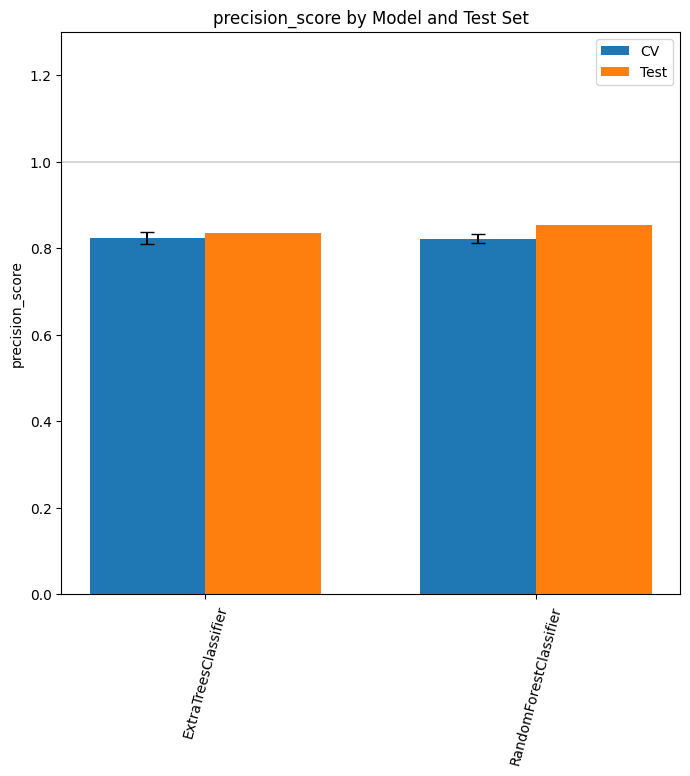

<Figure size 640x480 with 0 Axes>

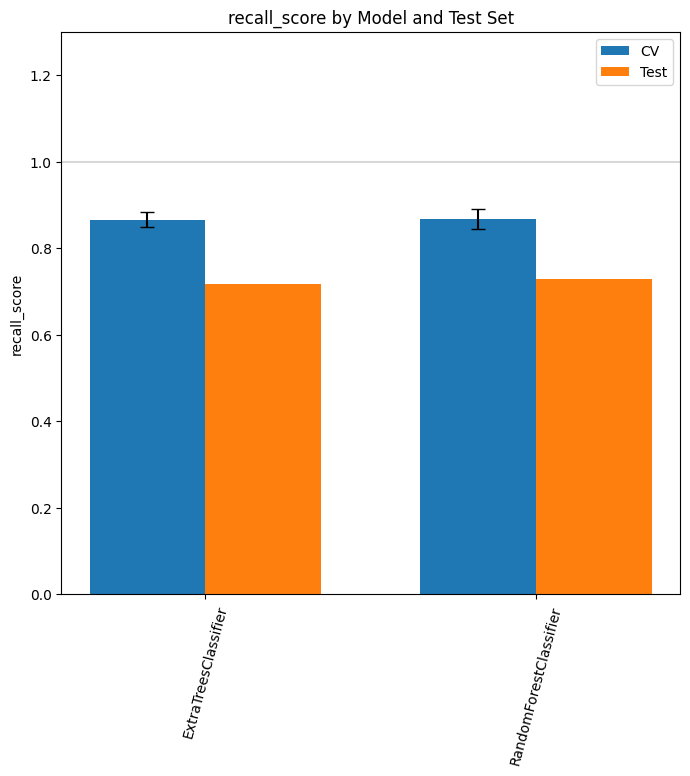

<Figure size 640x480 with 0 Axes>

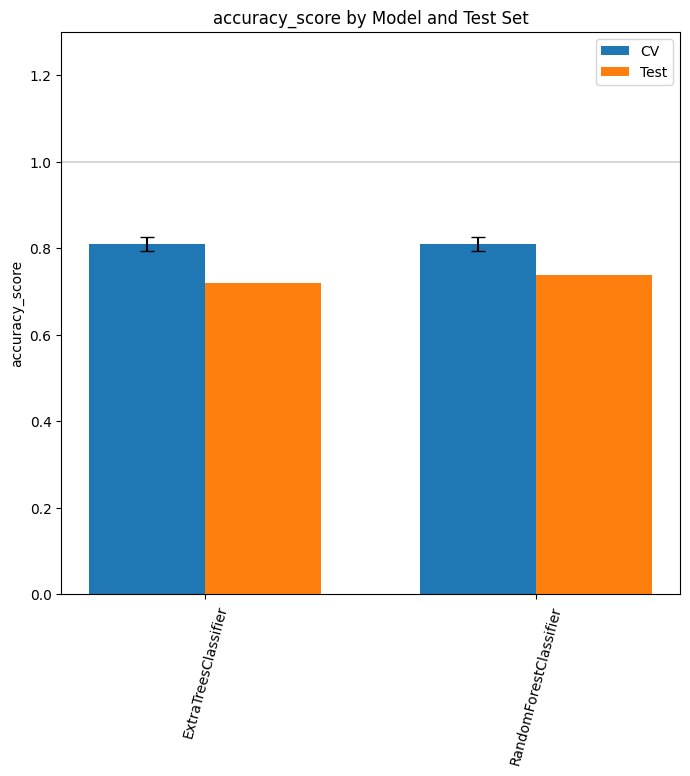

<Figure size 640x480 with 0 Axes>

In [12]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot(fitted_models)
figs, summary = plot.make(show=True, save=True, filename_prefix=f"qspr/models/ExtraTreesClassifier_metrics")

In [13]:
summary

,Metric,Model,TestSet,Value
0,f1_score,ExtraTreesClassifier,CV1.0,0.828979
1,matthews_corrcoef,ExtraTreesClassifier,CV1.0,0.559372
2,precision_score,ExtraTreesClassifier,CV1.0,0.806005
3,recall_score,ExtraTreesClassifier,CV1.0,0.853301
4,accuracy_score,ExtraTreesClassifier,CV1.0,0.790087
5,f1_score,ExtraTreesClassifier,CV2.0,0.838863
6,matthews_corrcoef,ExtraTreesClassifier,CV2.0,0.583789
7,precision_score,ExtraTreesClassifier,CV2.0,0.813793
8,recall_score,ExtraTreesClassifier,CV2.0,0.865526
9,accuracy_score,ExtraTreesClassifier,CV2.0,0.801749
